<a href="https://colab.research.google.com/github/huggoparcelly/rec-info/blob/main/In_Memory_Search_Engine_(Alef_Adonis%2C_Huggo_Parcelly%2C_Juan_Silva).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alunos:
- Álef Ádonis dos Santos Carlos - 120110407
- Huggo Parcelly da Silva - 120210155
- Juan Silva

# In-Memory Search Engine

Hoje vamos implementar um pequeno motor de busca para exercitar os principais conceitos vistos na disciplina até o momento.

Após a submissão de todas as soluções, iremos discutir/avaliar/comparar as implementações enviadas pelos grupos.

Durante a aula de discussão, os membros do grupo serão questionados sobre os detalhes da implementação. A pergunta poderá ser direcionada para um membro específico, sem que os demais possam ajudar a responder.

**INSTRUÇÕES**

Esta atividade deve ser feita em grupos de 3 alunos. Apenas 1 aluno precisa enviar pelo classroom. Não esqueçam de informar os nomes dos membros.

Além do envio pelo classroom, haverá um formulário para envio do link (basta 1 aluno preencher).

Cuidado: verifique se a opção de compartilhamento está no formato "todos com o link podem acessar". Caso não esteja compartilhado corretamente, a submissão será ignorada. ATENÇÃO: a última edição do arquivo deve ser antes do prazo de entrega.

**DESCRIÇÃO**

O motor de busca deverá ser capaz de ler os dados de um arquivo CSV com 2 colunas:

* id: o ID do documento (número inteiro sequencial)
* text: o texto do documento

Como a intenção é fazer um motor de busca bem simples, o índice invertido é mantido 100% em memória, na estrutura que julgarem mais adequada. Também não iremos nos preocupar com compressão de índice para economizar memória.

Os textos dos documentos devem passar por um pré-processamento antes de serem indexados.

A estratégia ranqueamento pode ser baseada em TF/IDF ou alguma estratégia simples.

O buscador **não** precisa fazer busca tolerante.

Há uma classe python pré-definida que deve existir, onde você deve criar os métodos. Porém, se quiser criar outras classes para serem usadas pela classe principal, não há problema.

Considerem que o buscador vai processar textos em **inglês**!

Bom trabalho!











# Arquitetura do Motor de Busca!

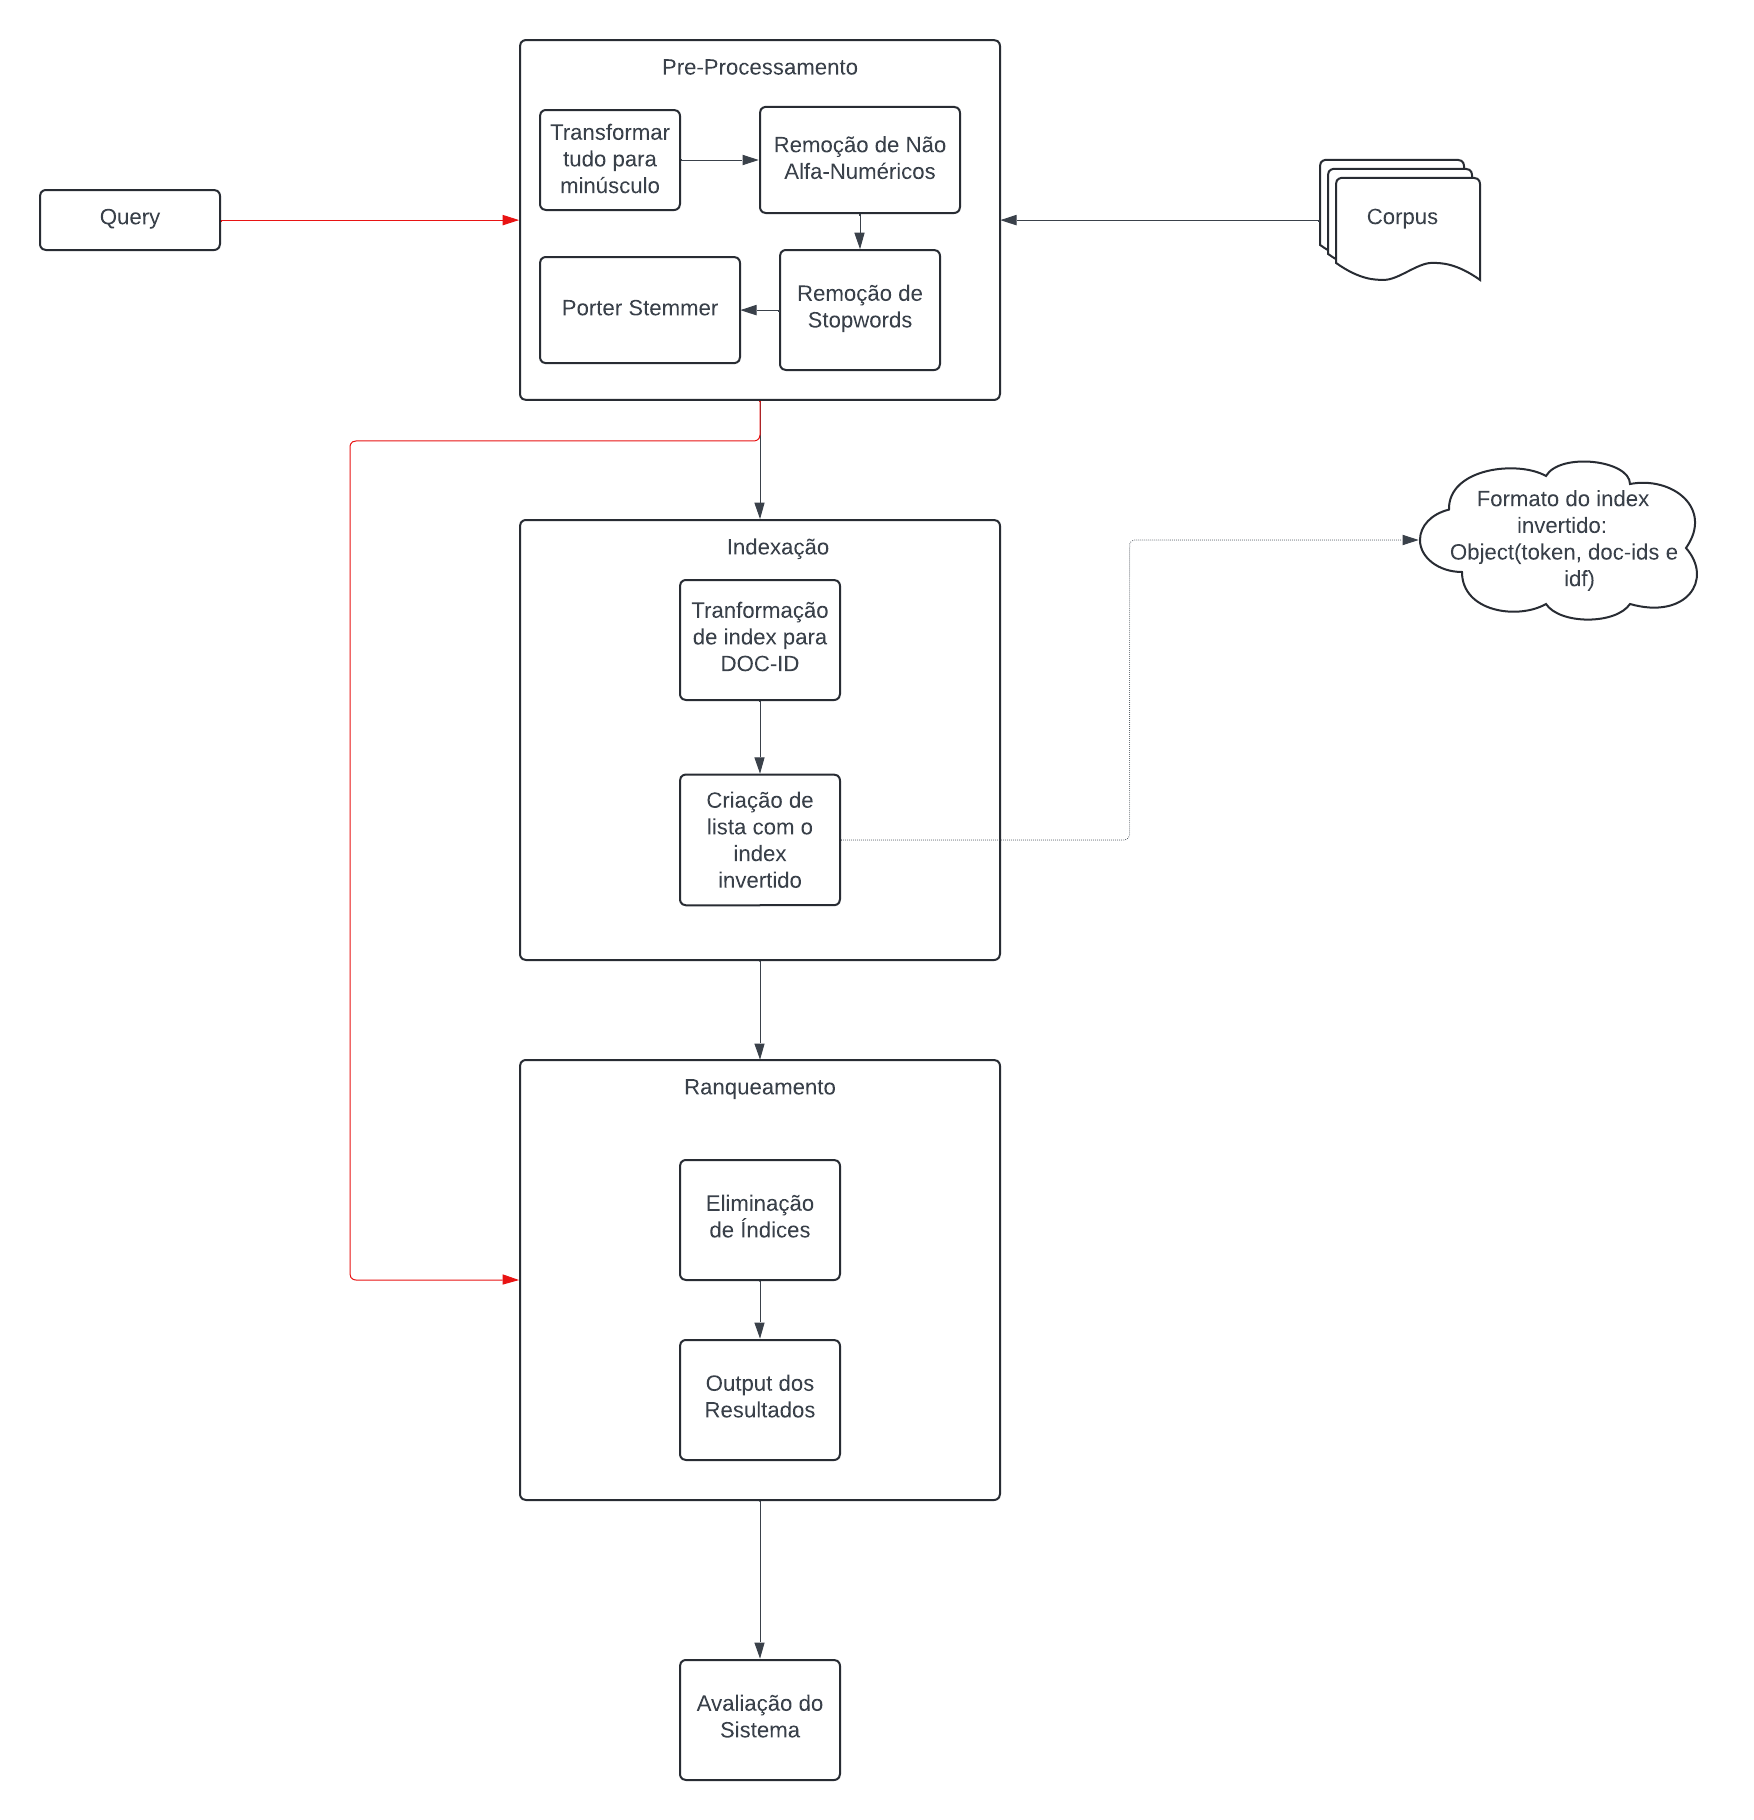

# Implementação

#Imports

In [ ]:
import string
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Leitura arquivo CSV
- No momento o arquivo csv foi gerado com dados mockados

In [ ]:
!gdown 1QIWaHC1sj6NhowksTS0lsldsJexnXrh0

Downloading...
From: https://drive.google.com/uc?id=1QIWaHC1sj6NhowksTS0lsldsJexnXrh0
To: /content/docs.csv
100% 1.72k/1.72k [00:00<00:00, 6.18MB/s]


In [ ]:
import pandas as pd

file_path = 'docs.csv'

df = pd.read_csv(file_path, sep=',')
df.head()

,id,text
0,1,Patient: I have been experiencing back and kne...
1,2,Patient: I've been having constant headaches. ...
2,3,Patient: My throat is quite inflamed. Doctor: ...
3,4,Patient: I have fever and chills. Doctor: You ...
4,5,Patient: I've been feeling extreme fatigue. Do...


In [ ]:
class Doc():

    def __init__(self, original_text):

        if not original_text:
            raise Exception("[ERROR] Document can not be empty or None Type.")

        self.origin_text = original_text

        self.origin_text.translate(str.maketrans('', '', string.punctuation)).split(" ")

        self.process_text = PreProcess().stemming(original_text)

        self.length = len(self.origin_text.translate(str.maketrans('', '', string.punctuation)).split(" "))

        self.tf = self.__term_frequency()

        self.word_index = [(i, word) for i, word in enumerate(self.process_text)]

    def __term_frequency(self,):
        tf = dict()
        for w in self.process_text:
            if w not in tf.keys():
                tf[w] = 1
            else:
                tf[w]+= 1

        return tf


## Processamento de texto
 - Aplica tokenização nas sentenças e depois nas palavras de cada sentença
 - Remove pontuação
 - Remove stop words
 - Stemming, usando Snowball Stemming

In [ ]:
class PreProcess():

    def __init__(self):
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.stop_words = set(stopwords.words("english")).union(stopwords.words("portuguese"))
        self.ps = SnowballStemmer("english")

    def tokenize_sentence(self, sentence):
        tokenized_sentence = word_tokenize(sentence)
        return " ".join([word.lower() for word in tokenized_sentence])

    def remove_punct(self, sentence):
        return self.tokenizer.tokenize(self.tokenize_sentence(sentence))

    def remove_stop_words(self, sentence):
        return [word for word in self.remove_punct(sentence) if word not in self.stop_words]

    def stemming(self, sentence):
        return [self.ps.stem(word) for word in self.remove_stop_words(sentence)]

## Indexação

In [ ]:
class InvertIndex():

    def inverted_index(self, doc):
        doc_process = doc.word_index

        inverted = {}
        for index, word in doc_process:
            locations = inverted.setdefault(word, [])
            locations.append(index)
        return inverted


    def inverted_index_add(self, inverted, doc_id, doc_index, doc_):
        for word, locations in doc_index.items():
            indices = inverted.setdefault(word, {})
            indices[doc_id] = [locations[0], doc_.tf[word]]
        return inverted

    def build_inverted_index(self, array_Docs):
        inverted = {}
        documents = {}

        for i, doc in array_Docs.items():
            documents['doc'+str(i+1)] = doc

        for doc_id, doc_ in documents.items():
            doc_index = self.inverted_index(doc_)
            self.inverted_index_add(inverted, doc_id, doc_index, doc_)

        return inverted

## Classe Principal do Buscador

In [ ]:
class InMemSearchEngine():

	def __init__(self, path_corpus_file):

		self.path_to_corpus_file = path_corpus_file

		self.corpus_df = pd.read_csv(self.path_to_corpus_file)

		self.pre_proc_corpus = self.__pre_process()

		self.corpus_size = len(self.corpus_df)

		self.inverted_index = InvertIndex().build_inverted_index(self.pre_proc_corpus)

		# Números Mágicos
		self.k = 1.5
		self.b = 0.75


	def __pre_process(self):
		try:
			return {row.id: Doc(row.text) for row in self.corpus_df.itertuples()}
		except Exception as e:
			print(f"Erro ao pré-processar o corpus: {e}")

	def ranking(self, query):
		scores = [0] * self.corpus_size

		for term in query:
			if term in self.inverted_index:
				idf = math.log((self.corpus_size + 1) / len(self.inverted_index[term]))
				for doc_id, tf in self.inverted_index[term].items():
					id_doc_corpus = int(doc_id.split('doc')[1]) - 1
					doc_length = self.pre_proc_corpus[id_doc_corpus].length
					tf_term = tf[1]
					scores[id_doc_corpus -1] += idf * tf_term * (self.k + 1) / (tf_term + self.k * (1 - self.b + self.b * doc_length / self.corpus_size))
		return scores

	def ranked_docs(self, docs_ranked):
		return {id_doc: score for id_doc, score in enumerate(docs_ranked)}


	def search(self, query):
		if

		pre_proc_query = PreProcess().stemming(query)

		docs_ranked_key = self.ranked_docs(self.ranking(pre_proc_query))

		return [id+1 for id, _ in sorted(docs_ranked_key.items(), key=lambda t:t[1], reverse=True)]



## Exemplo de código mostrando como a classe vai ser usada nos testes

In [ ]:
path_corpus_file =  file_path         #'./corpus.csv'

se = InMemSearchEngine(path_corpus_file)

query = 'fever chills tests'
results = se.search(query) # o retorno desta função é uma lista de inteiros, representando os IDs dos documentos recuperados.

print(results)

[4, 7, 15, 5, 6, 14, 1, 2, 3, 8, 9, 10, 11, 12, 13]


In [ ]:
# for query in df['query']:
#     print(se.search(query))

# #to evaluate

# def evaluate_search_engine(search_engine, ground_truth_ids, ground_truth_rels):
#     relevant_docs = ground_truth_ids[ground_truth_rels == 1]

#     search_results = search_engine.search(query)  # Substitua 'query' pela consulta real

#     precision = len(set(search_results) & set(relevant_docs)) / len(search_results)
#     recall = len(set(search_results) & set(relevant_docs)) / len(relevant_docs)

#     print("Resultados do mecanismo de busca:", search_results)
#     print("Documentos relevantes:", relevant_docs.tolist())
#     print("Precision:", precision)
#     print("Recall:", recall)

# ground_truth_ids = df["ground_truth_ids"]
# ground_truth_rels = df["ground_truth_ids_rels"]

# evaluate_search_engine(se, ground_truth_ids, ground_truth_rels)